<img src='img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

# Discover Greek Fires in 2023

During August 2023, wildfires raged for days in the northern Greece. Read more about the extent of the Greek fires [here](https://user.eumetsat.int/resources/case-studies/massive-fires-in-northern-greece).

The dynamics and extent of the fires were monitored by different sensors and data. This notebook covers the following data products:

- [Sentinel-3 SLSTR Near-Real-Time - Fire Radiative Power - Level 2](#s3_frp)
- [Sentinel-3 SLSTR Near-Real-Time - Aerosol Optical Depth - Level 2](#s3_aod)
- [Metop-A/B/C GOME-2 - Absorbing Aerosol Index - Level 3](#gome2_aai)
- [Metop-A/B IASI - Total Column Carbon Monoxide - Level 2](#iasi_co)

<hr>

#### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import requests
import io
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

from fnmatch import filter

#### Helper functions

In [3]:
%run helper_functions.ipynb

#### Questions

In [4]:
%run Questions.ipynb

#### Set the geographical extent

In [5]:
latmin = 30
latmax = 50
lonmin = 15
lonmax = 40

<hr>

<div class="alert alert-block alert-warning">
⚠️ <b>Braistorming time!</b>
Run the cell below to visualize the question.
</div>

In [6]:
show_question_1()

<IPython.core.display.Javascript object>

<hr>

<div class="alert alert-block alert-info">
<b>How to access the data</b>
</div>

Data can be downloaded using:
* A [EUMETSAT Earth Observation Portal account](https://eoportal.eumetsat.int/) to download Sentinel-3 data from the [EUMETSAT Data Store](https://data.eumetsat.int/)
* IASI Level 2 are disseminated in the `netCDF` format and can be downloaded via the [IASI catalog](https://iasi.aeris-data.fr/catalog/)
* GOME-2 AAI Level 3 data are available for download via either [AC SAF](https://acsaf.org/) in native `hdf5` format or via <a href='http://www.temis.nl/airpollution/absaai/' target='_blank'>TEMIS</a>, a web-based service for atmospheric satellite data products maintained by KNMI. TEMIS provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C. You can go to the <a href='https://www.temis.nl/airpollution/absaai/#GOME2_AAI' target='_blank'>download page</a>, select under `GOME-2 / MetOp-A AAI daily gridded` the year `2023` and then click on `21-22-23 August 2023`. The download of the selected NetCDF file will start.

<div class="alert alert-block alert-info">
<b>Data in this Training</b>
</div>

For the scope of this School we demonstrate how to access a publicly accessible Swift object storage bucket. We use Python's `requests` library to interact with the Swift bucket and stream the file directly into memory without the need for downloading it locally. 
1. Accessing the Public Swift Bucket: We use the [`requests`](https://requests.readthedocs.io/en/latest/) library to send HTTP requests to the Swift bucket URL and retrieve the contents of the bucket. The notebook handles streaming the file directly to memory.

2. Streaming `NetCDF` files: Instead of downloading the file locally, we stream it using requests and convert the response content into a file-like object using io.BytesIO.

3. Loading Data with `Xarray`: [`Xarray`](https://docs.xarray.dev/en/stable/) is a powerful Python library for handling labeled multi-dimensional arrays, and it provides native support for NetCDF files. We use Xarray to open the streamed file and load it into a dataset for further exploration and analysis.

Alternate Approach for S3 Buckets: If the bucket was hosted on Amazon S3 or another S3-compatible object storage, a different approach would be recommended. In such cases, Python's `boto3` library could be used to directly access the S3 bucket and download or stream files.

This code sends a `GET request` to the base URL of the Swift object storage using requests. It prints the HTTP status code to check if the request was successful, followed by the content of the response (response.text), which shows the directory and file listing from the bucket.

In [7]:
# Base URL to the bucket
base_url = "https://s3.waw3-2.cloudferro.com/swift/v1/act6/"

# Send a GET request to the base URL
response = requests.get(base_url)
if response.status_code == requests.codes.ok:
    print('Status ok\n')
else:
    response.raise_for_status()
print(response.text)

all_paths_list = response.text.split('\n')

Status ok

data/
data/metop/
data/metop/gome2_aai/
data/metop/gome2_aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230821-fv1.9.nc
data/metop/gome2_aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230822-fv1.9.nc
data/metop/gome2_aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230823-fv1.9.nc
data/metop/iasi_co/
data/metop/iasi_co/IASI_METOPB_L2_CO_20230821_ULB-LATMOS_V6.7.0_total_column.nc
data/metop/iasi_co/IASI_METOPB_L2_CO_20230822_ULB-LATMOS_V6.7.0_total_column.nc
data/metop/iasi_co/IASI_METOPB_L2_CO_20230823_ULB-LATMOS_V6.7.0_total_column.nc
data/metop/iasi_hcooh/
data/metop/iasi_hcooh/IASI_METOPB_L2_HCOOH_COLUMN_20230821_ULB-LATMOS_V1.0.0.nc
data/metop/iasi_hcooh/IASI_METOPB_L2_HCOOH_COLUMN_20230822_ULB-LATMOS_V1.0.0.nc
data/metop/iasi_hcooh/IASI_METOPB_L2_HCOOH_COLUMN_20230823_ULB-LATMOS_V1.0.0.nc
data/s3/aod/
data/s3/aod/S3A_SL_2_AOD____20230821T075719_20230821T080218_20230821T101134_0299_102_249______MAR_O_NR_003.SEN3/
data/s3/aod/S3A_SL_2_AOD____20230821T075719_20230821T080218_20230821T101134_0299_102_24

The list above is a little cumbersome to read. Let's list all the directories up to 4 levels deep.

In [8]:
# If a single path contains less or equal than 4 '/', return a directory name
all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
list(np.unique(all_directories_list))

['data',
 'data/metop',
 'data/metop/gome2_aai',
 'data/metop/iasi_co',
 'data/metop/iasi_hcooh',
 'data/s3/aod',
 'data/s3/aod/S3A_SL_2_AOD____20230821T075719_20230821T080218_20230821T101134_0299_102_249______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230821T080220_20230821T080718_20230821T102123_0299_102_249______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230821T191758_20230821T192257_20230821T214919_0299_102_256______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230822T091208_20230822T091707_20230822T112619_0299_102_264______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230822T091707_20230822T092206_20230822T113452_0299_102_264______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230822T203209_20230822T203708_20230822T230345_0299_102_271______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230823T084601_20230823T085100_20230823T105938_0299_102_278______MAR_O_NR_003.SEN3',
 'data/s3/aod/S3A_SL_2_AOD____20230823T085102_20230823T085601_20230823T111

## <a id='s3_frp'></a>Sentinel-3 Near-Real-Time SLSTR Fire Radiative Power

<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [9]:
show_question_2()

<IPython.core.display.Javascript object>

#### Load `S3 NRT SLSTR FRP MWIR` data with xarray's `xr.open_dataset` function

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are 2 variables of interest: 
* `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW] - to detect fires with temperatures less than 1000 Kelvin
* `FRP_SWIR` - Fire Radiative Power computed from SWIR channel (2.25 um) [MW] - to detect fires with higher temperatures (>1100 Kelvin)

A data file also contains a set of `attributes`, which give you more information about the data file and the data it contains, e.g the `start_time` and `stop_time` or the `product_name`.

This code fetches a NetCDF file from a Swift object storage using requests. It streams the file content to avoid downloading it fully, then converts the response into a file-like object using io.BytesIO. The file is opened as an Xarray dataset for exploration and analysis. If the file fetch is unsuccessful, the HTTP status code is printed to identify the error.

In [10]:
# Define the file(s) to visualise
date = '20230823'
orbit_number = '278'
data_directory = 'data/s3/frp/'
filename = "FRP_Merged_MWIR1kmStandard_SWIR1km.nc"

data_paths = filter(all_paths_list, data_directory + '*' + date + '*_' + orbit_number + '___*.SEN3/')

frp_xrs = list()

for data_path in data_paths:
    
    # Stream the file content
    response = requests.get(base_url + data_path + filename, stream=True)
    
    # Ensure the request is successful
    if response.status_code == 200:
        # Convert the streamed content into a file-like object
        file_obj = io.BytesIO(response.content)
    
        # Open the file with xarray as a NetCDF dataset
        frp_xrs.append(xr.open_dataset(file_obj))
        print(f"File opened: {data_path}")
    else:
        print(f"Failed to fetch file: {response.status_code}")

frp_xr = xr.concat(frp_xrs, dim='merged_MWIR1kmStandard_SWIR1km')

File opened: data/s3/frp/S3A_SL_2_FRP____20230823T084701_20230823T085001_20240820T180335_0179_102_278______MAR_D_NR_003.SEN3/
File opened: data/s3/frp/S3A_SL_2_FRP____20230823T085001_20230823T085301_20240820T180413_0179_102_278______MAR_D_NR_003.SEN3/


In [11]:
frp_xr

<xarray.Dataset> Size: 8kB
Dimensions:                            (merged_MWIR1kmStandard_SWIR1km: 108)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Data variables: (12/22)
    i                                  (merged_MWIR1kmStandard_SWIR1km) int16 216B ...
    j                                  (merged_MWIR1kmStandard_SWIR1km) int32 432B ...
    latitude                           (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    longitude                          (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    time                               (merged_MWIR1kmStandard_SWIR1km) datetime64[ns] 864B ...
    FRP_SWIR                           (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    ...                                 ...
    confidence_clear_sky_freezing      (merged_MWIR1kmStandard_SWIR1km) int8 108B ...
    confidence_clear_sky_split_window  (merged_MWIR1kmStandard_SWIR1km) int8 108B ...
    solar_zenith                       (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    solar_azimuth                      (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    sat_zenith                         (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
    sat_azimuth                        (merged_MWIR1kmStandard_SWIR1km) float32 432B ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20230823T084701_20230823T085001_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 03.01
    ...                     ...
    absolute_orbit_number:  39136
    start_time:             2023-08-23T08:47:01.054452Z
    stop_time:              2023-08-23T08:50:01.054452Z
    processing_baseline:    FRP_NRT.003.00.00
    track_offset:           998
    start_offset:           14353

#### Load `latitude`, `longitude`, `start_time` and `stop_time` information

You can already load the `latitude` , `longitude`, `start_time` and `stop_time` information, which will be required for the regridding process.

In [12]:
lat_frp = frp_xr['latitude']
lat_frp

lon_frp = frp_xr['longitude']
lat_frp

<xarray.DataArray 'latitude' (merged_MWIR1kmStandard_SWIR1km: 108)> Size: 432B
array([50.126442, 50.08057 , 50.02079 , 50.782913, 50.041718, 50.51309 ,
       49.98195 , 49.949665, 49.256413, 49.573162, 49.313564, 49.269436,
       46.885437, 46.883514, 46.76298 , 46.30642 , 47.159966, 45.41245 ,
       45.403168, 45.90328 , 46.00278 , 44.903378, 45.351383, 46.085827,
       44.597454, 42.19902 , 42.26879 , 42.96092 , 42.222202, 41.341003,
       41.33272 , 41.41712 , 41.11292 , 41.120655, 41.10452 , 41.115513,
       41.095352, 41.09383 , 41.107956, 41.1064  , 41.096966, 41.097145,
       41.053684, 41.044548, 41.06874 , 41.063892, 41.01714 , 41.1845  ,
       41.00947 , 41.00795 , 41.001125, 40.99962 , 41.62468 , 40.99198 ,
       40.983704, 41.016228, 41.01447 , 41.005688, 40.995068, 40.98943 ,
       40.98759 , 40.951584, 40.949867, 40.947792, 40.945995, 40.939507,
       40.924976, 41.073902, 41.07118 , 41.064465, 40.863914, 40.08092 ,
       40.079914, 40.75951 , 39.71394 , 38.378693, 38.370544, 38.34688 ,
       38.13645 , 38.133797, 38.14008 , 38.134907, 38.13241 , 38.127163,
       38.124428, 38.1217  , 38.137203, 38.134434, 38.131706, 38.113396,
       38.127773, 38.12505 , 38.122334, 38.106724, 38.127464, 38.12482 ,
       38.122166, 38.11951 , 38.116814, 38.117958, 38.115295, 38.112736,
       38.11012 , 38.1074  , 38.104645, 38.24562 , 38.10959 , 38.10692 ],
      dtype=float32)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:      Latitude - Standard FRP MWIR, FRP SWIR Coarse Resolution ...
    standard_name:  FRP_latitude_SWIR_1km
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0

In [13]:
start_time = frp_xr.start_time

stop_time = frp_xr.stop_time
stop_time

'2023-08-23T08:50:01.054452Z'

#### Define variables for `plotting` and `gridding`

Let us also define some variables for `plotting` and the `gridding` process. These are examples of sampling sizes of the gridded FRP values, feel free to change them. Remember, that finer grid will result in longer computations.

In [14]:
sampling_lat_FRP_grid = 0.4        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.4        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 150.         # Max Integrated FRP value, for plots

Now, let us go through the variable `MWIR` and let us load, mask, regrid and visualize them.

#### <a id='load_mwir'></a>Load, mask and regrid `FRP computed from MWIR channel (3.7 um)`

The first step is to load the `FRP_MWIR` data variable from the loaded `netCDF` file. You, see that the variable contains a total of 108 fire entries.

In [15]:
frp_mwir = frp_xr['FRP_MWIR']
frp_mwir

<xarray.DataArray 'FRP_MWIR' (merged_MWIR1kmStandard_SWIR1km: 108)> Size: 432B
array([   7.3955007,    6.231415 ,    7.983832 ,    8.077292 ,
          7.2379827,    8.899489 ,   12.871342 ,   14.294216 ,
          9.501457 ,    7.713856 ,    9.402595 ,    7.07477  ,
         16.432432 ,   16.129993 ,   17.005865 ,   27.287647 ,
         14.73175  ,   37.41988  ,   24.388603 ,    6.714429 ,
          5.856988 ,   11.735089 ,    5.8634872,   39.21551  ,
         12.311933 ,   82.6105   ,   93.20154  ,   11.300213 ,
         11.075658 ,   12.899727 ,   16.975538 ,   15.731702 ,
         74.05612  ,    9.984662 ,   23.705683 ,   34.8951   ,
         25.783106 ,   14.778527 ,   50.14718  ,   30.589462 ,
         47.801136 ,   25.550306 ,   48.14047  ,  214.72475  ,
         13.180726 ,   14.233441 ,   47.952255 ,   38.56778  ,
         91.2423   ,  412.4353   ,   96.86681  ,   84.86646  ,
          6.512585 ,  108.480576 ,   26.683924 ,   98.22589  ,
         33.963123 ,   54.070007 ,   33.990704 ,  144.57649  ,
         92.64335  ,  315.29565  ,  136.08589  ,   87.92513  ,
         18.26386  ,   30.646595 ,   81.50919  ,  102.76825  ,
         47.3769   ,  122.7201   ,   27.320461 ,  256.47873  ,
        790.2396   ,   14.959837 ,   32.7016   ,  111.41934  ,
         59.369793 ,   28.236135 ,   11.768705 ,  119.301346 ,
        141.17839  ,  129.85939  ,  337.42392  ,  231.29396  ,
        164.25533  , 1186.8608   ,   12.72404  ,  142.46869  ,
        225.11583  ,  380.19165  ,  302.85294  ,  105.39851  ,
         38.97521  ,   65.129486 ,  278.33432  ,  134.18457  ,
         49.924946 , 1427.8534   ,  329.28073  ,  265.3241   ,
         85.432    ,  101.8154   ,  730.50903  ,   66.20615  ,
         18.977068 ,   93.584755 ,  102.84256  ,   34.532787 ],
      dtype=float32)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power (FRP) MWIR - Standard FRP MWIR. The refe...
    units:      MW

<br>

The next step is to extract (mask) only the valid. Valid pixels are different to -1. You can use the function [generate_masked_array()](../functions.ipynb#generate_masked_array) to extract the right pixels. There are 108 fire entries from the `MWIR` channel. These fires have a temperature less than 1000 Kelvin.

In [16]:
masked_frp_mwir = generate_masked_array(xarray=frp_mwir, 
                                        mask=frp_mwir, 
                                        threshold=-1.,
                                        operator='!=', 
                                        drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (merged_MWIR1kmStandard_SWIR1km: 108)> Size: 432B
array([   7.3955007,    6.231415 ,    7.983832 ,    8.077292 ,
          7.2379827,    8.899489 ,   12.871342 ,   14.294216 ,
          9.501457 ,    7.713856 ,    9.402595 ,    7.07477  ,
         16.432432 ,   16.129993 ,   17.005865 ,   27.287647 ,
         14.73175  ,   37.41988  ,   24.388603 ,    6.714429 ,
          5.856988 ,   11.735089 ,    5.8634872,   39.21551  ,
         12.311933 ,   82.6105   ,   93.20154  ,   11.300213 ,
         11.075658 ,   12.899727 ,   16.975538 ,   15.731702 ,
         74.05612  ,    9.984662 ,   23.705683 ,   34.8951   ,
         25.783106 ,   14.778527 ,   50.14718  ,   30.589462 ,
         47.801136 ,   25.550306 ,   48.14047  ,  214.72475  ,
         13.180726 ,   14.233441 ,   47.952255 ,   38.56778  ,
         91.2423   ,  412.4353   ,   96.86681  ,   84.86646  ,
          6.512585 ,  108.480576 ,   26.683924 ,   98.22589  ,
         33.963123 ,   54.070007 ,   33.990704 ,  144.57649  ,
         92.64335  ,  315.29565  ,  136.08589  ,   87.92513  ,
         18.26386  ,   30.646595 ,   81.50919  ,  102.76825  ,
         47.3769   ,  122.7201   ,   27.320461 ,  256.47873  ,
        790.2396   ,   14.959837 ,   32.7016   ,  111.41934  ,
         59.369793 ,   28.236135 ,   11.768705 ,  119.301346 ,
        141.17839  ,  129.85939  ,  337.42392  ,  231.29396  ,
        164.25533  , 1186.8608   ,   12.72404  ,  142.46869  ,
        225.11583  ,  380.19165  ,  302.85294  ,  105.39851  ,
         38.97521  ,   65.129486 ,  278.33432  ,  134.18457  ,
         49.924946 , 1427.8534   ,  329.28073  ,  265.3241   ,
         85.432    ,  101.8154   ,  730.50903  ,   66.20615  ,
         18.977068 ,   93.584755 ,  102.84256  ,   34.532787 ],
      dtype=float32)
Dimensions without coordinates: merged_MWIR1kmStandard_SWIR1km
Attributes:
    long_name:  Fire Radiative Power (FRP) MWIR - Standard FRP MWIR. The refe...
    units:      MW

<br>

Let us store the number of of hotspots / fires in total and per category as variables.

In [17]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(108, 108)

#### Generate a gridded FRP array

Let us compute the gridded FRP information. The gridded FRP is the integration (sum) of FRP within a grid cell.
You can use the function [slstr_frp_gridding](../functions.ipynb#slstr_frp_gridding()) to do it.

Apply the function `slstr_frp_gridding` to the `frp_mwir` data array.

In [18]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(parameter_array=frp_mwir,
                                                       parameter='mwir',
                                                       lat_min=latmin, 
                                                       lat_max=latmax, 
                                                       lon_min=lonmin, 
                                                       lon_max=lonmax, 
                                                       sampling_lat_FRP_grid=sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid=sampling_lon_FRP_grid, 
                                                       n_fire=n_fire_MWIR,
                                                       lat_frp=lat_frp,
                                                       lon_frp=lon_frp)

FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[30.2, 30.2, 30.2, ..., 30.2, 30.2, 30.2],
        [30.6, 30.6, 30.6, ..., 30.6, 30.6, 30.6],
        [31. , 31. , 31. , ..., 31. , 31. , 31. ],
        ...,
        [49.4, 49.4, 49.4, ..., 49.4, 49.4, 49.4],
        [49.8, 49.8, 49.8, ..., 49.8, 49.8, 49.8],
        [50.2, 50.2, 50.2, ..., 50.2, 50.2, 50.2]], dtype=float32),
 array([[15.2, 15.6, 16. , ..., 39.2, 39.6, 40. ],
        [15.2, 15.6, 16. , ..., 39.2, 39.6, 40. ],
        [15.2, 15.6, 16. , ..., 39.2, 39.6, 40. ],
        ...,
        [15.2, 15.6, 16. , ..., 39.2, 39.6, 40. ],
        [15.2, 15.6, 16. , ..., 

<br>

Mask out the invalid pixels for plotting. You can use numpy's function `np.ma.masked_array()` for the masking.

In [19]:
mask_valid = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)
D_mwir = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_valid)
D_mwir

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

<br>

Calculate some statistics, e.g. mean, std, min and max, and add them to a string that can be integrated into the final plot.

In [20]:
textstr_1 = 'Total number 1km hot-spots = ' + str(n_fire_MWIR)


FRP_sum = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'


#### Visualize the masked data array with matplotlib's `pcolormesh()` function

You can make use of the function [visualize_s3_frp()](../functions.ipynb#visualize_s3_frp), which uses matplotlib's `pcolormesh` function to visualize a numpy array.

The function takes the following keyword arguments:
* `data`: DataArray with fire hotspots
* `lat`: Latitude information
* `lon`: Longitude information
* `unit`: Unit of the data values
* `longname`: Long name of the data
* `textstr_1`: Text that contains the total number of 1km hot-spots
* `textstr_2`: Text that contains summary statistics of the data
* `vmax`: Maximum value to be visualized

Now, you can apply the function [visualize_s3_frp()](../functions.ipynb#visualize_s3_frp) and plot the `FRP computed from MWIR channel` data. Additionally, you can take information such as `units` from the data variable attributes.

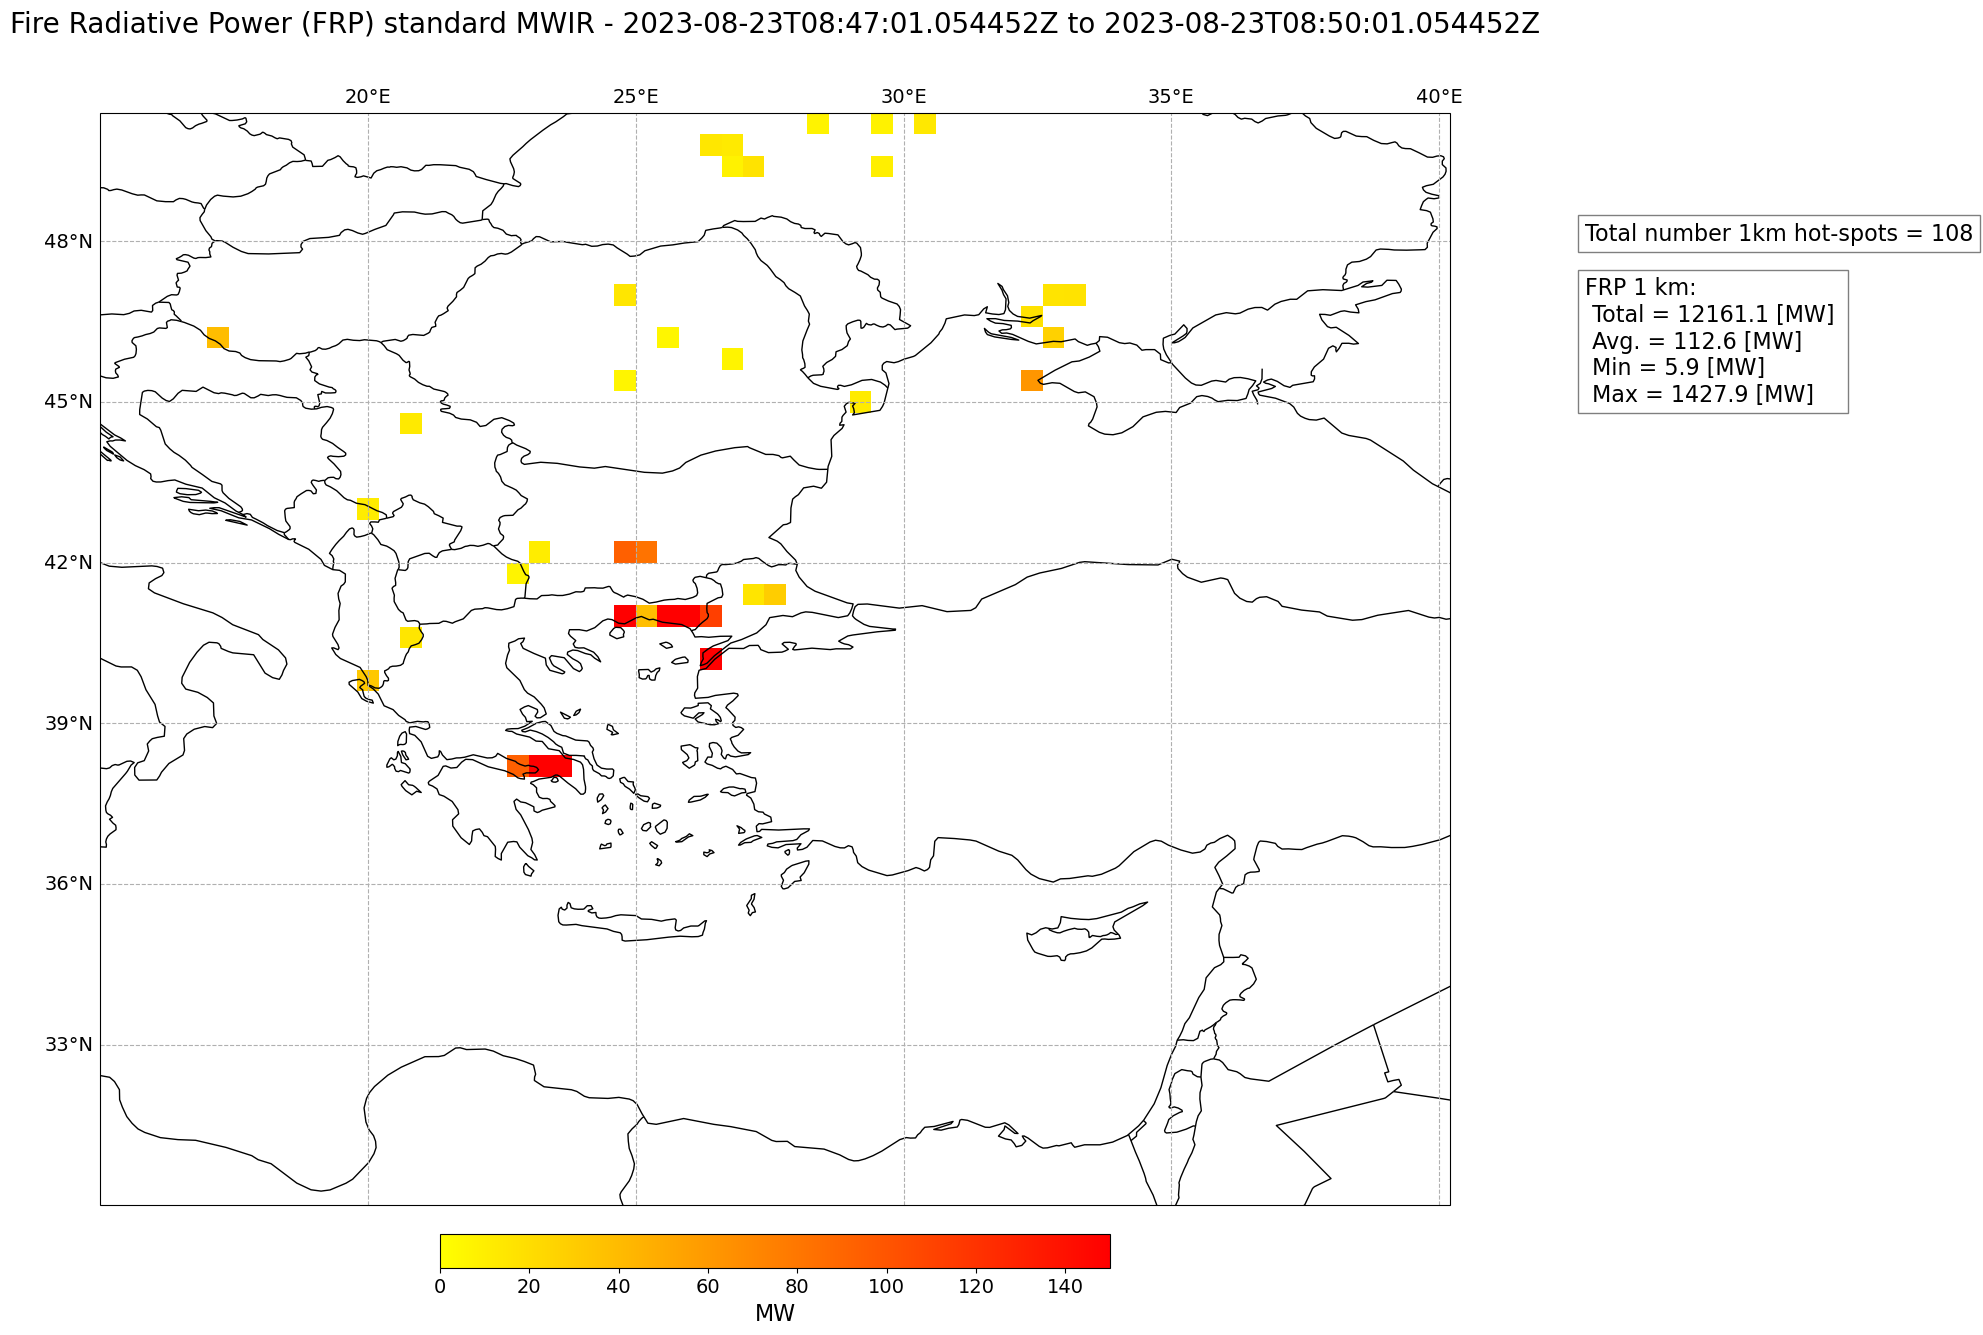

In [21]:
unit = frp_mwir.units
vmax = FRP_plot_max_grid

visualize_s3_frp(data=D_mwir[:,:],
                 lat=lat_grid, 
                 lon=lon_grid, 
                 unit=unit, 
                 longname=f"Fire Radiative Power (FRP) standard MWIR - {start_time} to {stop_time}", 
                 textstr_1=textstr_1, 
                 textstr_2=textstr_2, 
                 vmax=FRP_plot_max_grid)

<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [22]:
show_question_3()

<IPython.core.display.Javascript object>

<br>

## <a id='s3_aod'></a>Sentinel-3 Near-Real-Time SLSTR Aerosol Optical Depth

#### <a id='load'></a>Load Sentinel-3 SLSTR AOD data

The Sentinel-3 Near-Real-Time SLSTR Aerosol Optical Depth data are disseminated in `netCDF`. `netCDF` data can be loaded with the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `xr.open_dataset()`. 

You see that the data file contains two `dimensions`:
* `columns` (along-track) and
* `rows` (across-track).

It further contains an long list of `data variables`, including:
* `AOD_550`,
* `AOD_550_uncertainty`,
* `AOD_550_Ocean_NonFiltered`,
* `AOD_550_Land_Experimental_PostFiltered`,
...

A data file also contains a set of `attributes`, which give you more information about the data file and the data it contains, e.g the `start_time` and `stop_time` or the `product_name`.

In [23]:
# Define the file(s) to visualise
date = '20230823'
orbit_number = '278'
data_directory = 'data/s3/aod/'
filename = "NRT_AOD.nc"

# Filter the right files out of all entire file list
data_paths = filter(all_paths_list, data_directory + '*' + date + '*_' + orbit_number + '___*.SEN3/')

aod_xrs = list()
for data_path in data_paths:

    # Stream the file content
    response = requests.get(base_url + data_path + filename, stream=True)
    
    # Ensure the request is successful
    if response.status_code == 200:
        # Convert the streamed content into a file-like object
        file_obj = io.BytesIO(response.content)
    
        # Open the file with xarray as a NetCDF dataset
        aod_xrs.append(xr.open_dataset(file_obj))
        print(f"File opened: {data_path}")
    else:
        print(f"Failed to fetch file: {response.status_code}")

# Concatenate along track
aod_xr = xr.concat(aod_xrs, dim='rows')
del(aod_xrs)

File opened: data/s3/aod/S3A_SL_2_AOD____20230823T084601_20230823T085100_20230823T105938_0299_102_278______MAR_O_NR_003.SEN3/S3A_SL_2_AOD____20230823T084601_20230823T085100_20230823T105938_0299_102_278______MAR_O_NR_003.SEN3/
File opened: data/s3/aod/S3A_SL_2_AOD____20230823T085102_20230823T085601_20230823T111006_0299_102_278______MAR_O_NR_003.SEN3/S3A_SL_2_AOD____20230823T085102_20230823T085601_20230823T111006_0299_102_278______MAR_O_NR_003.SEN3/


In [24]:
aod_xr

<xarray.Dataset> Size: 15MB
Dimensions:                                (rows: 422, columns: 157)
Coordinates:
    longitude                              (rows, columns) float32 265kB 15.3...
Dimensions without coordinates: rows, columns
Data variables: (12/57)
    AOD_550                                (rows, columns) float32 265kB nan ...
    AOD_550_Land                           (rows, columns) float32 265kB nan ...
    AOD_550_uncertainty                    (rows, columns) float32 265kB nan ...
    AOD_550_uncertainty_Land               (rows, columns) float32 265kB nan ...
    AOD_550_Merged_OceanLand               (rows, columns) float32 265kB nan ...
    AOD_670                                (rows, columns) float32 265kB nan ...
    ...                                     ...
    scattering_angle_oblique               (rows, columns) float32 265kB 0.0 ...
    cloud_fraction_nadir                   (rows, columns) float32 265kB nan ...
    cloud_fraction_oblique                 (rows, columns) float32 265kB nan ...
    aod_quality_flags                      (rows, columns) uint16 133kB 2048 ...
    SLN_L1b_quality_flags                  (rows, columns) uint32 265kB 42949...
    SLO_L1b_quality_flags                  (rows, columns) uint32 265kB 42949...
Attributes: (12/17)
    title:                  Surface directional Reflectance, retrieved and de...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_AOD____20230823T084601_20230823T085100_2...
    institution:            MAR
    source:                 IPF-SL-2-AOD 04.00
    ...                     ...
    absolute_orbit_number:  39136
    start_time:             2023-08-23T08:46:00.756335Z
    stop_time:              2023-08-23T08:51:00.142342Z
    processing_baseline:    AOD_NRT.003.00.00
    track_offset:           105
    start_offset:           1467

#### <a id='extract'></a>Extract Aerosol Optical Depth variables

The next step is to extract the variables of interest. Let us select the following two variables:
* `AOD_550`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers ocean surfaces.*)
* `AOD_550_Land`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers land surfaces.*)

Both `DataArrays` have two dimensions (`rows` and `columns`) and the following attributes, which provide additional information about the variables:
* `start_time`
* `stop_time`
* `coordinates`

In [25]:
aod_ocean = aod_xr.AOD_550
aod_land = aod_xr.AOD_550_Land
print(aod_ocean)
print(' ')
print(aod_land)

<xarray.DataArray 'AOD_550' (rows: 422, columns: 157)> Size: 265kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    longitude  (rows, columns) float32 265kB 15.32 15.47 15.62 ... 23.46 23.54
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Aerosol optical thickness at 550 nm - Best quality (post-...
    standard_name:  atmosphere_optical_thickness_due_to_ambient_aerosol
    valid_min:      0.0
    valid_max:      4.001
 
<xarray.DataArray 'AOD_550_Land' (rows: 422, columns: 157)> Size: 265kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...

You can also load `latitude`, `longitude`, `start_time` and `stop_time` information, which can be used later for visualizing the variables.

In [26]:
lat_nc = aod_xr.latitude
lon_nc = aod_xr.longitude
print(lat_nc)
print(' ')
print(lon_nc)

<xarray.DataArray 'latitude' (rows: 422, columns: 157)> Size: 265kB
array([[55.97035 , 55.963524, 55.9566  , ..., 52.855553, 52.822845,
        52.789917],
       [55.887547, 55.880703, 55.87376 , ..., 52.775715, 52.743076,
        52.71044 ],
       [55.804745, 55.797882, 55.79092 , ..., 52.6966  , 52.663013,
        52.63095 ],
       ...,
       [21.149158, 21.134792, 21.120401, ..., 18.400955, 18.3792  ,
        18.359762],
       [21.065819, 21.051434, 21.037025, ..., 18.316948, 18.296381,
        18.276173],
       [20.982475, 20.968075, 20.953648, ..., 18.233912, 18.213308,
        18.19258 ]], dtype=float32)
Coordinates:
    longitude  (rows, columns) float32 265kB 15.32 15.47 15.62 ... 23.46 23.54
Dimensions without coordinates: rows, columns
Attributes:
    long_name:      Latitude at pixel centre
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0
 
<xarray.DataArray 'longitude' (rows: 422, columns: 157)> Size: 26

You can also load `start_time` and `stop_time` attributes

In [27]:
start_time = aod_xr.start_time

stop_time = aod_xr.stop_time
stop_time

'2023-08-23T08:51:00.142342Z'

#### <a id='visualize'></a> Visualize AOD Ocean and AOD Land variables

The final step is to visualize both variables, Aerosol Optical Depth over ocean and land together in one plot. You can use the function [visualize_s3_aod](../functions.ipynb#visualize_s3_aod) to do so.

The function takes the following keyword arguments (kwargs):
* `aod_ocean`: DataArray with AOD values over ocean
* `aod_land`: DataArray with AOD values over land
* `latitude`: DataArray with latitude information
* `longitude`: DataArray with longitude information
* `title`: Title of the plot
* `unit`: Unit of AOD
* `vmin` and `vmax`: Minimum and maximum values to be displayed on the map
* `color_scale`: Color scale the data shall be represented
* `projection`: Projection of the map

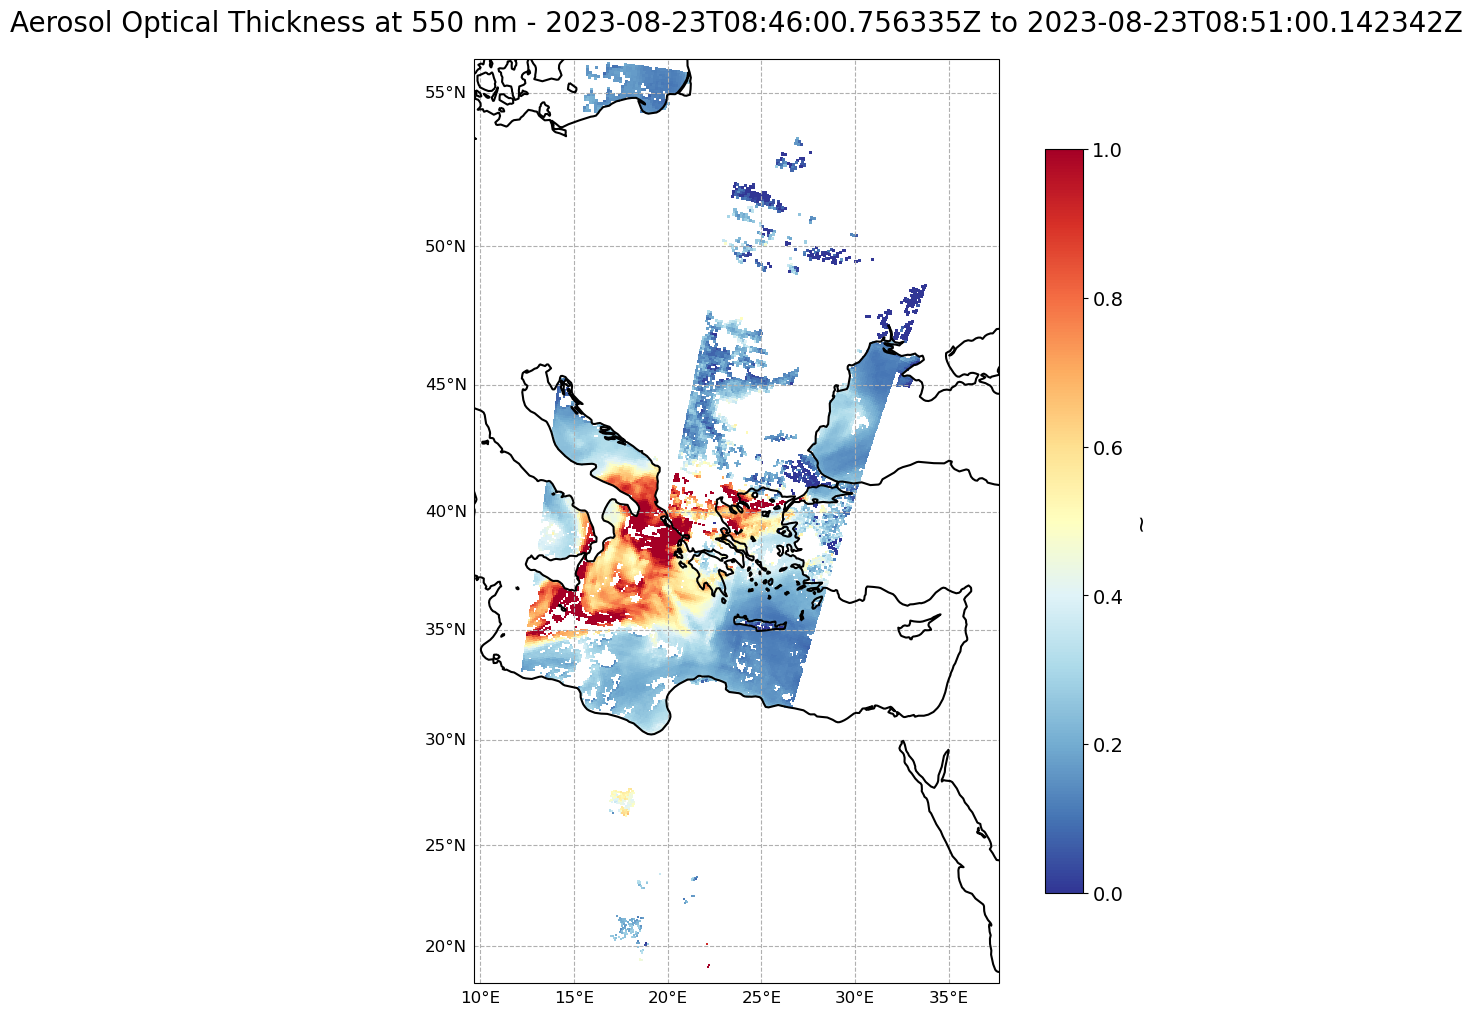

In [28]:
visualize_s3_aod(aod_ocean=aod_ocean, 
                 aod_land=aod_land, 
                 latitude=lat_nc, 
                 longitude=lon_nc, 
                 title=f'Aerosol Optical Thickness at 550 nm - {start_time} to {stop_time}', 
                 unit='~', 
                 vmin=0.,
                 vmax=1.0,
                 color_scale='RdYlBu_r',
                 projection=ccrs.Mercator())

<br>

<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [29]:
show_question_4()

<IPython.core.display.Javascript object>

## <a id='gome2_aai'></a>AC SAF Metop-A/B/C GOME-2 Absorbing Aerosol Index (AAI) Level 3

#### Load a time-series of daily AC SAF GOME-2 Level 3 AAI data into one a `xarray.Dataset` object

The function `xr.open_mfdataset()` from the xarray library allows the openening of multiple NetCDF files at once. You have to specify the dimension the files shall be concatenated on. It can be an existing dimension of the data file or a dimension that will newly be created.

Let us open the daily gridded AAI data from Metop-A for 11 days from 5 to 15 September 2020 and we specify `time` as a new dimension the data files shall be concatenated on.

After you loaded the multiple files in a `xarray.Dataset` with the function `open_mfdataset()`, you have to select again `absorbing_aerosol_index` as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).

In [30]:
data_path = "data/metop/gome2_aai/"

# List of filenames
filenames = [
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230821-fv1.9.nc",
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230822-fv1.9.nc",
    "ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20230823-fv1.9.nc"
]

# List to store file-like objects
file_objs = []

# Loop over filenames, download and store file-like objects
for filename in filenames:
    file_url = base_url + data_path + filename
    response = requests.get(file_url, stream=True)
    
    if response.status_code == 200:
        # Convert the streamed content into a file-like object and add to the list
        file_objs.append(io.BytesIO(response.content))
    else:
        print(f"Failed to fetch {filename}: {response.status_code}")

# Use xarray to open the datasets as a multi-file dataset
if file_objs:
    # Open multiple file-like objects using xarray
    datasets = [xr.open_dataset(file_obj) for file_obj in file_objs]
    ds_b = xr.concat(datasets, dim="time") 
else:
    print("No files were downloaded successfully.")

In [31]:
ds_b

<xarray.Dataset> Size: 2MB
Dimensions:                  (longitude: 360, latitude: 180, time: 3)
Coordinates:
  * longitude                (longitude) float32 1kB -179.5 -178.5 ... 179.5
  * latitude                 (latitude) float32 720B -89.5 -88.5 ... 88.5 89.5
Dimensions without coordinates: time
Data variables:
    absorbing_aerosol_index  (time, longitude, latitude) float32 778kB nan .....
    number_of_observations   (time, longitude, latitude) int16 389kB 0 0 ... 16
    solar_zenith_angle       (time, longitude, latitude) float32 778kB nan .....
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      ESA CCI absorbing aerosol index level 3 product
    description:                Multi-Sensor AAI field for 21-08-2023
    institution:                Royal Netherlands Meteorological Institute (K...
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-aerosol-cci.org
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    comment:                    Sun glint and solar eclipse events were filte...
    license:                    ESA CCI Data Policy: free and open access
    summary:                    This dataset contains absorbing aerosol index...

In [32]:
aai_b=ds_b['absorbing_aerosol_index']
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 3, longitude: 360,
                                             latitude: 180)> Size: 778kB
array([[[        nan,         nan,         nan, ..., -0.25283033,
         -0.18957669, -0.05952134],
        [        nan,         nan,         nan, ..., -0.23286152,
         -0.19321358, -0.07503253],
        [        nan,         nan,         nan, ..., -0.24307944,
         -0.19759807, -0.19302344],
        ...,
        [        nan,         nan,         nan, ..., -0.2523297 ,
         -0.21041812, -0.08030885],
        [        nan,         nan,         nan, ..., -0.26133293,
         -0.2343834 , -0.13492392],
        [        nan,         nan,         nan, ..., -0.30579013,
         -0.18976137, -0.1058718 ]],

       [[        nan,         nan,         nan, ..., -0.21577498,
         -0.16413686, -0.25432414],
        [        nan,         nan,         nan, ..., -0.18422225,
         -0.17315567, -0.22459716],
        [        nan,         nan,         nan, ..., -0.11675324,
         -0.16210933, -0.31069595],
...
        [        nan,         nan,         nan, ..., -0.4031594 ,
         -0.21737497, -0.21270153],
        [        nan,         nan,         nan, ..., -0.39366904,
         -0.19257207, -0.3432876 ],
        [        nan,         nan,         nan, ..., -0.2503915 ,
         -0.19778179, -0.222762  ]],

       [[        nan,         nan,         nan, ..., -0.0603057 ,
         -0.1298108 , -0.35877275],
        [        nan,         nan,         nan, ..., -0.06857532,
         -0.11174545, -0.3955225 ],
        [        nan,         nan,         nan, ..., -0.04648441,
         -0.10568429, -0.37498498],
        ...,
        [        nan,         nan,         nan, ..., -0.10682949,
         -0.16239136, -0.45282334],
        [        nan,         nan,         nan, ..., -0.08355381,
         -0.1389804 , -0.33321628],
        [        nan,         nan,         nan, ..., -0.06625508,
         -0.14852513, -0.34973606]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

#### Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the metadata of a single data file, you can see that the only metadata attribute that contains the valid time step is the `description` attribute.

The first step is to retrieve the metadata attribute `description` and split the resulting string object at the positions with a space. The day string is the fourth position of the resulting string.

The `description` attribute can be accessed directly from the `xr_single_file` object.

In [33]:
start_day = ds_b.description.split()[4]
start_day

'21-08-2023'

With the help of the Python library `pandas`, you can build a `DateTime` time series for 24 consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `aai_concat` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DateTime` information from 5 to 15 September 2020.

In [34]:
time_coords = pd.date_range(datetime.strptime(start_day, '%d-%m-%Y'),periods=len(ds_b.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23'], dtype='datetime64[ns]', freq=None)

The final step is to assign the pandas time series object `time_coords` to the `aai_concat` DataArray object. You can use the `assign_coords()` function from the xarray library.

The result is that only the `satellite` dimension does not have any coordinates defined.

In [35]:
aai_b = aai_b.assign_coords(time=time_coords)
aai_b

<xarray.DataArray 'absorbing_aerosol_index' (time: 3, longitude: 360,
                                             latitude: 180)> Size: 778kB
array([[[        nan,         nan,         nan, ..., -0.25283033,
         -0.18957669, -0.05952134],
        [        nan,         nan,         nan, ..., -0.23286152,
         -0.19321358, -0.07503253],
        [        nan,         nan,         nan, ..., -0.24307944,
         -0.19759807, -0.19302344],
        ...,
        [        nan,         nan,         nan, ..., -0.2523297 ,
         -0.21041812, -0.08030885],
        [        nan,         nan,         nan, ..., -0.26133293,
         -0.2343834 , -0.13492392],
        [        nan,         nan,         nan, ..., -0.30579013,
         -0.18976137, -0.1058718 ]],

       [[        nan,         nan,         nan, ..., -0.21577498,
         -0.16413686, -0.25432414],
        [        nan,         nan,         nan, ..., -0.18422225,
         -0.17315567, -0.22459716],
        [        nan,         nan,         nan, ..., -0.11675324,
         -0.16210933, -0.31069595],
...
        [        nan,         nan,         nan, ..., -0.4031594 ,
         -0.21737497, -0.21270153],
        [        nan,         nan,         nan, ..., -0.39366904,
         -0.19257207, -0.3432876 ],
        [        nan,         nan,         nan, ..., -0.2503915 ,
         -0.19778179, -0.222762  ]],

       [[        nan,         nan,         nan, ..., -0.0603057 ,
         -0.1298108 , -0.35877275],
        [        nan,         nan,         nan, ..., -0.06857532,
         -0.11174545, -0.3955225 ],
        [        nan,         nan,         nan, ..., -0.04648441,
         -0.10568429, -0.37498498],
        ...,
        [        nan,         nan,         nan, ..., -0.10682949,
         -0.16239136, -0.45282334],
        [        nan,         nan,         nan, ..., -0.08355381,
         -0.1389804 , -0.33321628],
        [        nan,         nan,         nan, ..., -0.06625508,
         -0.14852513, -0.34973606]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 24B 2023-08-21 2023-08-22 2023-08-23
Attributes:
    long_name:  absorbing aerosol index averaged for each grid cell
    units:      1

#### Visualize AC SAF AAI data with data from the three satellite Metop-B combined on one single grid

<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [36]:
# show_question_7()

The final step is to visualize the the AC SAF Aerosol Absorbing Index data for one time step. You can use the function [visualize_pcolormesh()](../functions.ipynb#visualize_pcolormesh) for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, and you can add the valid time step to the title of the plot.

The resulting plot shows elevated AAI levels over Greece on 23 August 2023.

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'absorbing aerosol index averaged for each grid cell 2023-08-23'}>)

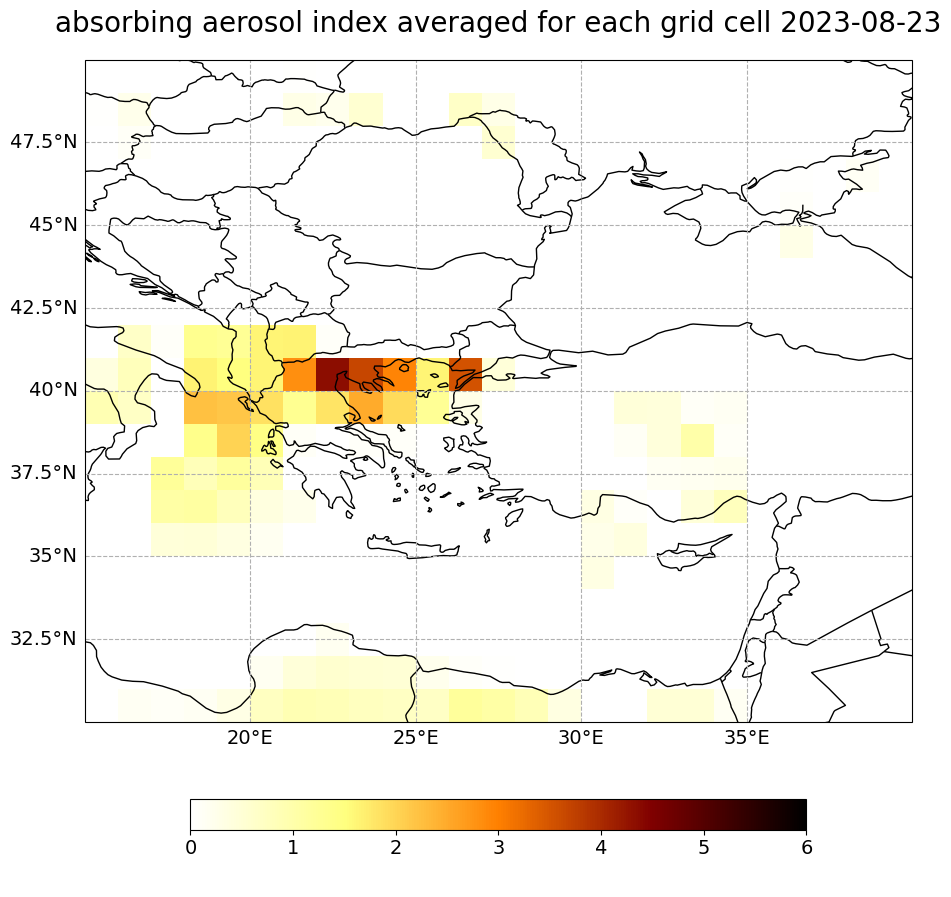

In [37]:
day_index = 2 # 0 for 21 Sept, 1 for 22 Sept, 2 for 23 Sept
visualize_pcolormesh(data_array=aai_b[day_index,:,:].T,
                     longitude=aai_b.longitude, 
                     latitude=aai_b.latitude,
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=' ',
                     long_name=aai_b.long_name + ' ' + str(aai_b.time[day_index].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=6,
                    latmin=latmin,
                     latmax=latmax,
                     lonmin=lonmin,
                     lonmax=lonmax,
                    set_global=False)


<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [38]:
show_question_5()

<IPython.core.display.Javascript object>

## <a id='iasi_co'></a>Metop-B IASI - Total Column Carbon Monoxide - Level 2

#### Load netCDF data with `xarray`

IASI Level 2 data from the [IASI portal](https://iasi.aeris-data.fr/) are disseminated in the `netCDF` format. You can use Python's library [xarray](http://xarray.pydata.org/en/stable/index.html) to access and manipulate datasets in `netCDF` format. Xarray's function `xr.open_dataset()` enables you to open a `netCDF` file. Once loaded, you can inspect the data structure.

You see, that the data is a 3-dimensional vector with more than 550,000 individual entries for the `time` dimension. `latitude`, `longitude` and other parameters are stored as individual data variables.

In [39]:
# Define the data path
data_path = "data/metop/iasi_co/"
filename = "IASI_METOPB_L2_CO_20230823_ULB-LATMOS_V6.7.0_total_column.nc"

# Stream the file content
response = requests.get(base_url + data_path + filename, stream=True)

# Ensure the request is successful
if response.status_code == 200:
    # Convert the streamed content into a file-like object
    file_obj = io.BytesIO(response.content)

    # Open the file with xarray as a NetCDF dataset
    iasi_file = xr.open_dataset(file_obj)
    print(f"File opened")
else:
    print(f"Failed to fetch file: {response.status_code}")

File opened


In [40]:
iasi_file

<xarray.Dataset> Size: 24MB
Dimensions:                 (time: 550546)
Coordinates:
  * time                    (time) float64 4MB 5.251e+08 5.251e+08 ... 5.252e+08
Data variables:
    CO_total_column         (time) float32 2MB ...
    CO_total_column_error   (time) float32 2MB ...
    latitude                (time) float32 2MB ...
    longitude               (time) float32 2MB ...
    retrieval_quality_flag  (time) int32 2MB ...
    time_string             (time) |S16 9MB ...
Attributes: (12/32)
    title:                       IASI/METOPB ULB-LATMOS carbon monoxide (CO) ...
    institution:                 ULB-LATMOS for algorithm development ; EUMET...
    product_version:             6.7.0
    history:                     Tue Aug  6 12:10:24 2024: ncks -v time_strin...
    summary:                     This dataset contains Level 2 carbon monoxid...
    source:                      EUMETSAT IASI Level 2 carbon monoxide (CO) d...
    ...                          ...
    creator_name:                ULB-LATMOS
    contact_email:               contact form at http://iasi.aeris-data.fr/co...
    data_policy:                 see https://iasi.aeris-data.fr/data-use-policy/
    time_coverage_start:         20230823T000000Z
    time_coverage_end:           20230823T235959Z
    NCO:                         netCDF Operators version 5.0.6 (Homepage = h...

As a next step, you can select the variable `CO_total_column`, which holds data values for total column carbon monoxide.

In [41]:
co = iasi_file['CO_total_column']
co

<xarray.DataArray 'CO_total_column' (time: 550546)> Size: 2MB
[550546 values with dtype=float32]
Coordinates:
  * time     (time) float64 4MB 5.251e+08 5.251e+08 ... 5.252e+08 5.252e+08
Attributes:
    units:                                                  mol m-2
    long_name:                                              retrieved carbon ...
    standard_name:                                          atmosphere_mole_c...
    ancillary_variables:                                    CO_total_column_e...
    multiplication_factor_to_convert_to_molecules_per_cm2:  6.02214086e+19

#### Load data into a xarray.DataArray with the function `generate_xr_from_1D_vec`

With the help of the function [generate_xr_from_1D_vec()](../functions.ipynb#generate_xr_from_1D_vec), you can generate a `xarray.DataArray` object, with `latitude` and `longitude` values as coordinates and the total column carbon monoxide information as data values. This data structure will be helpful for plotting and masking the data.

Further, you can retrieve the information for the variables `long_name`, `unit` and `variable name` from the attributes of the data object `co`.

In [42]:
iasi_co_da = generate_xr_from_1D_vec(file=iasi_file,
                                     lat_path='latitude', 
                                     lon_path='longitude',
                                     variable=co, 
                                     parameter_name=co.name, 
                                     longname=co.long_name, 
                                     no_of_dims=1, 
                                     unit=co.units)

iasi_co_da

<xarray.DataArray 'CO_total_column' (ground_pixel: 550546)> Size: 2MB
array([0.01875287, 0.01868997, 0.01747026, ..., 0.01949361, 0.01977983,
       0.01846112], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 2MB -55.77 -55.55 -55.81 ... -47.23 -46.86
    longitude  (ground_pixel) float32 2MB 122.4 121.4 121.7 ... -26.1 -25.27
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

#### Load quality flag information

The IASI Level 2 data files provide you information on the quality for each data point. This information is useful to generate a quality mask and to mask out data points with a non sufficient quality.

In order to do so, you have to load the quality flag variable `retrieval_quality_flag` from the data file. The pixels with a `quality flag = 2` are the most reliable pixels. Pixels with a `quality flag = 1 or 0` shall be masked out.

In [43]:
qf = iasi_file['retrieval_quality_flag']
qf

<xarray.DataArray 'retrieval_quality_flag' (time: 550546)> Size: 2MB
[550546 values with dtype=int32]
Coordinates:
  * time     (time) float64 4MB 5.251e+08 5.251e+08 ... 5.252e+08 5.252e+08
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    comment:    = 2 for the most reliable pixels; = 1 for the valuable pixels...

You can re-use the [generate_xr_from_1D_vec()](../functions.ipynb#generate_xr_from_1D_vec) function again in order to generate a `xarray.DataArray` with the quality flag information.

In [44]:
iasi_co_qf_da = generate_xr_from_1D_vec(file=iasi_file,
                                        lat_path='latitude', 
                                        lon_path='longitude', 
                                        variable=qf, 
                                        parameter_name=qf.name, 
                                        longname=qf.long_name, 
                                        no_of_dims=1, 
                                        unit='-')
iasi_co_qf_da

<xarray.DataArray 'retrieval_quality_flag' (ground_pixel: 550546)> Size: 2MB
array([1, 1, 2, ..., 2, 2, 2], dtype=int32)
Coordinates:
    latitude   (ground_pixel) float32 2MB -55.77 -55.55 -55.81 ... -47.23 -46.86
    longitude  (ground_pixel) float32 2MB 122.4 121.4 121.7 ... -26.1 -25.27
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieval quality flag summarizing processing flags
    units:      -

#### Mask the Total Column Carbon Monoxide data

The quality flag information can now be used to mask the `xarray.DataArray` with the data values. You can make use of the function [generate_masked_array()](../functions.ipynb#generate_masked_array), where you can specify which pixels shall remain and which ones shall be eliminated. All data points with a `quality flag = 2` shall be kept, all others shall be masked out.

You see that the number of data points reduced to just a bit less than 400,000 instead of more than 500,000.

In [45]:
iasi_co_masked = generate_masked_array(xarray=iasi_co_da,
                                       mask=iasi_co_qf_da,
                                       threshold=2,
                                       operator='=')
iasi_co_masked

<xarray.DataArray (ground_pixel: 406062)> Size: 2MB
array([0.01747026, 0.01945747, 0.0170137 , ..., 0.01949361, 0.01977983,
       0.01846112], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 2MB -55.81 -55.64 -55.39 ... -47.23 -46.86
    longitude  (ground_pixel) float32 2MB 121.7 121.8 120.8 ... -26.1 -25.27
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  retrieved carbon monoxide total column in mole/m2
    units:      mol m-2

#### Convert the Total Column Carbon Monoxide data from mol/m<sup>2</sup> to molecules/cm<sup>2</sup>

The last step before visualizing the total column carbon monoxide information is to convert the data from `mol/m2` to `molecules/cm2`. The loaded data variable `co` has an attribute called `multiplication_factor_to_convert_to_molecules_per_cm2`, which is used to convert the data values.

In [46]:
iasi_co_masked_converted = iasi_co_masked*co.multiplication_factor_to_convert_to_molecules_per_cm2
iasi_co_masked_converted 

<xarray.DataArray (ground_pixel: 406062)> Size: 2MB
array([1.0520837e+18, 1.1717566e+18, 1.0245887e+18, ..., 1.1739323e+18,
       1.1911694e+18, 1.1117544e+18], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 2MB -55.81 -55.64 -55.39 ... -47.23 -46.86
    longitude  (ground_pixel) float32 2MB 121.7 121.8 120.8 ... -26.1 -25.27
Dimensions without coordinates: ground_pixel

#### Visualize the masked dataset with the function `visualize_scatter`

You can visualize the IASI Total Column Carbon Monoxide data with the function [visualize_scatter()](../functions.ipynb#visualize_scatter), which uses matplotlib's `scatterplot` function. You can set an `PlateCarree()` projection and focus on a region over Greece.

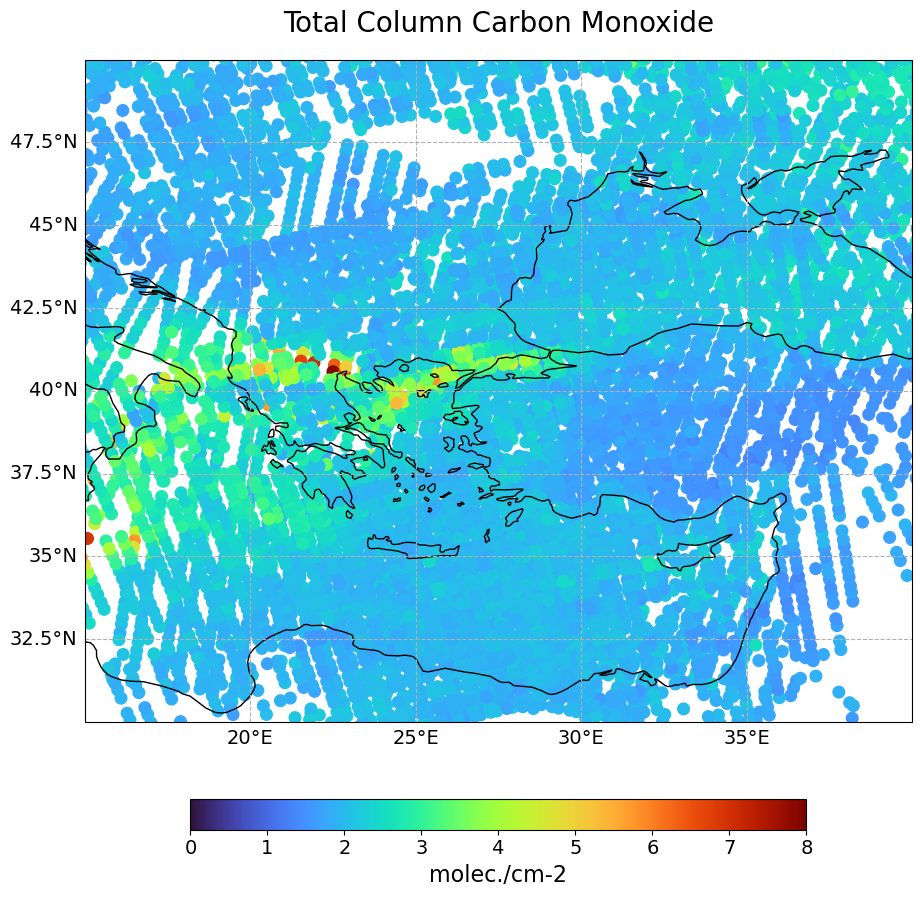

In [47]:
visualize_scatter(xr_dataarray=iasi_co_masked_converted, 
                  conversion_factor=1e-18,
                  projection=ccrs.PlateCarree(),
                  vmin=0, 
                  vmax=8, 
                  point_size=70, 
                  color_scale='turbo', 
                  unit='molec./cm-2', 
                  title='Total Column Carbon Monoxide',
                 latmin=latmin,
                 latmax=latmax,
                 lonmin=lonmin,
                 lonmax=lonmax)


<br>

<div class="alert alert-block alert-warning">
⚠️ <b>Question time!</b>
Run the cell below to visualize the question
</div>

In [48]:
show_question_6()

<IPython.core.display.Javascript object>

<br>

<hr>

### Additional information

This notebook was adapted from: [https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/30_case_studies/313_fire_california_2020.ipynb?ref_type=heads](https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/30_case_studies/313_fire_california_2020.ipynb?ref_type=heads)

<hr>

<p><img src='img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a>